In [55]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/validation.csv
/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv
/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv


In [56]:
!pip install tensorflow pandas numpy matplotlib rouge-score nltk tqdm

In [57]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import nltk

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from rouge_score import rouge_scorer

nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [58]:
# Load datasets
train_df = pd.read_csv('/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv')
val_df   = pd.read_csv('/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/validation.csv')
test_df  = pd.read_csv('/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv')

print(train_df.head())
print(train_df.columns)

                                         id  \
0  0001d1afc246a7964130f43ae940af6bc6c57f01   
1  0002095e55fcbd3a2f366d9bf92a95433dc305ef   
2  00027e965c8264c35cc1bc55556db388da82b07f   
3  0002c17436637c4fe1837c935c04de47adb18e9a   
4  0003ad6ef0c37534f80b55b4235108024b407f0b   

                                             article  \
0  By . Associated Press . PUBLISHED: . 14:11 EST...   
1  (CNN) -- Ralph Mata was an internal affairs li...   
2  A drunk driver who killed a young woman in a h...   
3  (CNN) -- With a breezy sweep of his pen Presid...   
4  Fleetwood are the only team still to have a 10...   

                                          highlights  
0  Bishop John Folda, of North Dakota, is taking ...  
1  Criminal complaint: Cop used his role to help ...  
2  Craig Eccleston-Todd, 27, had drunk at least t...  
3  Nina dos Santos says Europe must be ready to a...  
4  Fleetwood top of League One after 2-0 win at S...  
Index(['id', 'article', 'highlights'], dtype='obje

In [59]:
train_df = train_df[['article', 'highlights']]
val_df   = val_df[['article', 'highlights']]
test_df  = test_df[['article', 'highlights']]

train_df.dropna(inplace=True)
val_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [60]:
train_df = train_df.sample(20000, random_state=42)
val_df   = val_df.sample(3000, random_state=42)
test_df  = test_df.sample(3000, random_state=42)

In [61]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'"', '', text)
    text = re.sub(r"[^a-zA-Z ]", "", text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [62]:
train_df['article'] = train_df['article'].apply(clean_text)
train_df['highlights'] = train_df['highlights'].apply(clean_text)

val_df['article'] = val_df['article'].apply(clean_text)
val_df['highlights'] = val_df['highlights'].apply(clean_text)

test_df['article'] = test_df['article'].apply(clean_text)
test_df['highlights'] = test_df['highlights'].apply(clean_text)

# Add start and end tokens to summaries
train_df['highlights'] = train_df['highlights'].apply(lambda x: 'sostok ' + x + ' eostok')
val_df['highlights']   = val_df['highlights'].apply(lambda x: 'sostok ' + x + ' eostok')
test_df['highlights']  = test_df['highlights'].apply(lambda x: 'sostok ' + x + ' eostok')

In [63]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_TEXT_LEN = 300
MAX_SUM_LEN  = 40

# Article tokenizer
x_tokenizer = Tokenizer(num_words=50000, oov_token='<unk>')
x_tokenizer.fit_on_texts(train_df['article'])

# Summary tokenizer
y_tokenizer = Tokenizer(num_words=30000, oov_token='<unk>')
y_tokenizer.fit_on_texts(train_df['highlights'])

# Convert to sequences
x_train_seq = x_tokenizer.texts_to_sequences(train_df['article'])
x_val_seq   = x_tokenizer.texts_to_sequences(val_df['article'])
x_test_seq  = x_tokenizer.texts_to_sequences(test_df['article'])

y_train_seq = y_tokenizer.texts_to_sequences(train_df['highlights'])
y_val_seq   = y_tokenizer.texts_to_sequences(val_df['highlights'])
y_test_seq  = y_tokenizer.texts_to_sequences(test_df['highlights'])

# Padding
x_train = pad_sequences(x_train_seq, maxlen=MAX_TEXT_LEN, padding='post')
x_val   = pad_sequences(x_val_seq, maxlen=MAX_TEXT_LEN, padding='post')
x_test  = pad_sequences(x_test_seq, maxlen=MAX_TEXT_LEN, padding='post')

y_train = pad_sequences(y_train_seq, maxlen=MAX_SUM_LEN, padding='post')
y_val   = pad_sequences(y_val_seq, maxlen=MAX_SUM_LEN, padding='post')
y_test  = pad_sequences(y_test_seq, maxlen=MAX_SUM_LEN, padding='post')

In [64]:
VOCAB_SIZE_X = len(x_tokenizer.word_index) + 1
VOCAB_SIZE_Y = len(y_tokenizer.word_index) + 1

print("Article vocab:", VOCAB_SIZE_X)
print("Summary vocab:", VOCAB_SIZE_Y)

Article vocab: 162747
Summary vocab: 54671


In [66]:

MAX_TEXT_LEN = 300
MAX_SUM_LEN  = 40

VOCAB_X = 30000
VOCAB_Y = 20000

EMB_DIM = 128
LATENT_DIM = 256

BATCH_SIZE = 32
EPOCHS = 3

# Seq2Seq Model (NO Attention)

**Encoder**

In [67]:
EMB_DIM = 128
LATENT_DIM = 256

# Encoder
encoder_inputs = tf.keras.Input(shape=(MAX_TEXT_LEN,))
enc_emb = Embedding(VOCAB_SIZE_X, EMB_DIM, trainable=True)(encoder_inputs)

encoder_lstm = LSTM(LATENT_DIM, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

encoder_states = [state_h, state_c]

**Decoder**

In [90]:
decoder_inputs = tf.keras.Input(shape=(None,))

dec_emb_layer = Embedding(VOCAB_SIZE_Y, EMB_DIM, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

decoder_dense = Dense(VOCAB_SIZE_Y, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [69]:
seq2seq_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

seq2seq_model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

seq2seq_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_20      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_15        │ (None, 300, 128)  │ 20,831,616 │ input_layer_19[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_16        │ (None, None, 128) │  6,997,888 │ input_layer_20[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_17 (LSTM)      │ [(None, 256),     │    394,240 │ embedding_15[0][… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ [(None, None,     │    394,240 │ embedding_16[0][… │
│                     │ 256), (None,      │            │ lstm_17[0][1],    │
│                     │ 256), (None,      │            │ lstm_17[0][2]     │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, None,      │ 14,050,447 │ lstm_18[0][0]     │
│                     │ 54671)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 42,668,431 (162.77 MB)

 Trainable params: 42,668,431 (162.77 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
history_seq2seq = seq2seq_model.fit(
    [x_train, y_train[:, :-1]],
    y_train[:, 1:],
    validation_data=([x_val, y_val[:, :-1]], y_val[:, 1:]),
    batch_size=32,
    epochs=3
)

Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 132s 207ms/step - accuracy: 0.0762 - loss: 7.8470 - val_accuracy: 0.0997 - val_loss: 6.9434
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 129s 207ms/step - accuracy: 0.1224 - loss: 6.9723 - val_accuracy: 0.1116 - val_loss: 6.8257
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 129s 207ms/step - accuracy: 0.1333 - loss: 6.8513 - val_accuracy: 0.1252 - val_loss: 6.7124


# Seq2Seq WITH ATTENTION (Generic)

In [71]:
class AttentionLayer(tf.keras.layers.Layer):
    def call(self, decoder_out, encoder_out):
        score = tf.matmul(decoder_out, encoder_out, transpose_b=True)
        attn_weights = tf.nn.softmax(score, axis=-1)
        context = tf.matmul(attn_weights, encoder_out)
        return context

## Encoder

In [73]:
encoder_inputs = tf.keras.Input(shape=(MAX_TEXT_LEN,))
enc_emb = Embedding(VOCAB_SIZE_X, EMB_DIM)(encoder_inputs)

encoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

 ## Decoder

In [74]:
from tensorflow.keras.layers import Concatenate



decoder_inputs = tf.keras.Input(shape=(None,))
dec_emb = Embedding(VOCAB_SIZE_Y, EMB_DIM)(decoder_inputs)

decoder_lstm = LSTM(LATENT_DIM, return_sequences=True)
decoder_outputs = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

attention = AttentionLayer()
context = attention(decoder_outputs, encoder_outputs)

decoder_concat = Concatenate(axis=-1)([context, decoder_outputs])
decoder_dense = Dense(VOCAB_SIZE_Y, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat)

In [75]:
attn_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
attn_model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Compilation

In [76]:
### Compilation

history_attn = attn_model.fit(
    [x_train, y_train[:, :-1]],
    y_train[:, 1:],
    validation_data=([x_val, y_val[:, :-1]], y_val[:, 1:]),
    batch_size=32,
    epochs=3
)

Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 152s 240ms/step - accuracy: 0.0968 - loss: 7.6617 - val_accuracy: 0.1112 - val_loss: 6.8258
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 150s 239ms/step - accuracy: 0.1377 - loss: 6.8028 - val_accuracy: 0.1313 - val_loss: 6.6037
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 150s 239ms/step - accuracy: 0.1509 - loss: 6.6408 - val_accuracy: 0.1500 - val_loss: 6.4546


# Bahdanau Attention Model

In [77]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V  = Dense(1)

    def call(self, enc_out, dec_out):
        score = self.V(tf.nn.tanh(self.W1(enc_out) + self.W2(dec_out)))
        attn_weights = tf.nn.softmax(score, axis=1)
        context = attn_weights * enc_out
        return tf.reduce_sum(context, axis=1)

## Encoder

In [78]:
encoder_inputs = tf.keras.Input(shape=(MAX_TEXT_LEN,))
enc_emb = Embedding(VOCAB_SIZE_X, EMB_DIM)(encoder_inputs)

encoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

## Decoder + Bahdanau

In [96]:
decoder_inputs = tf.keras.Input(shape=(None,))
dec_emb = Embedding(VOCAB_SIZE_Y, EMB_DIM)(decoder_inputs)

decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

bahdanau_attention = BahdanauAttention(LATENT_DIM)
context = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Dense(LATENT_DIM)
)(decoder_outputs)
from tensorflow.keras.layers import Concatenate

decoder_concat = Concatenate(axis=-1)([context, decoder_outputs])

decoder_dense = Dense(VOCAB_SIZE_Y, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat)

## Compile

In [80]:
# Compilation 
bahdanau_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

bahdanau_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

hist_bahdanau = bahdanau_model.fit(
    [x_train, y_train[:, :-1]],
    y_train[:, 1:],
    validation_data=([x_val, y_val[:, :-1]], y_val[:, 1:]),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)

Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 159s 248ms/step - accuracy: 0.1192 - loss: 7.3625 - val_accuracy: 0.1544 - val_loss: 6.3168
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 155s 247ms/step - accuracy: 0.1739 - loss: 6.2843 - val_accuracy: 0.1779 - val_loss: 5.9949
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 154s 247ms/step - accuracy: 0.1981 - loss: 5.8468 - val_accuracy: 0.1909 - val_loss: 5.7705


# Luong Attention Model

In [81]:
class LuongAttention(tf.keras.layers.Layer):
    def call(self, enc_out, dec_out):
        score = tf.matmul(dec_out, enc_out, transpose_b=True)
        attn_weights = tf.nn.softmax(score, axis=-1)
        context = tf.matmul(attn_weights, enc_out)
        return context

## Decoder + Luong

In [102]:
decoder_lstm = LSTM(LATENT_DIM, return_sequences=True)
decoder_outputs = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

luong_attention = LuongAttention()
context = attention(encoder_outputs, decoder_outputs)

from tensorflow.keras.layers import Concatenate

decoder_concat = Concatenate(axis=-1)([context, decoder_outputs])

decoder_outputs = Dense(VOCAB_SIZE_Y, activation='softmax')(decoder_concat)

## Compile & Train

In [83]:
luong_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

luong_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

hist_luong = luong_model.fit(
    [x_train, y_train[:, :-1]],
    y_train[:, 1:],
    validation_data=([x_val, y_val[:, :-1]], y_val[:, 1:]),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)

Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 155s 245ms/step - accuracy: 0.1231 - loss: 7.2014 - val_accuracy: 0.1734 - val_loss: 6.0998
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 153s 244ms/step - accuracy: 0.1956 - loss: 6.0014 - val_accuracy: 0.1888 - val_loss: 5.8168
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 153s 244ms/step - accuracy: 0.2111 - loss: 5.6228 - val_accuracy: 0.1935 - val_loss: 5.7107


# ROUGE SCORE COMPARISON

## Build index ↔ word maps

In [84]:
LATENT_DIM = 256
EMBEDDING_DIM = 128

# Reverse target word index
reverse_target_word_index = y_tokenizer.index_word
target_word_index = y_tokenizer.word_index

## INFERENCE MODEL — SEQ2SEQ (NO ATTENTION)

## Encoder inf

In [85]:
encoder_model_seq2seq = tf.keras.Model(
    encoder_inputs,
    [state_h, state_c]
)

## Decoder inference

In [91]:
decoder_state_input_h = tf.keras.Input(shape=(LATENT_DIM,))
decoder_state_input_c = tf.keras.Input(shape=(LATENT_DIM,))


dec_emb_inf = dec_emb_layer(decoder_inputs)

decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm(
    dec_emb_inf,
    initial_state=[decoder_state_input_h, decoder_state_input_c]
)

decoder_outputs_inf = decoder_dense(decoder_outputs_inf)

decoder_model_seq2seq = tf.keras.Model(
    [decoder_inputs, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs_inf, state_h_inf, state_c_inf]
)


## INFERENCE MODEL — BAHDANAU ATTENTION

## Encoder Inf

In [92]:
encoder_model_bahdanau = tf.keras.Model(
    encoder_inputs,
    [encoder_outputs, state_h, state_c]
)

## Decoder Inf

In [110]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, RepeatVector
import tensorflow as tf

# Inputs
decoder_inputs = Input(shape=(1,))
decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
encoder_outputs_input = Input(shape=(MAX_TEXT_LEN, LATENT_DIM))  # encoder outputs

# Embedding
dec_emb_layer = Embedding(VOCAB_SIZE_Y, EMB_DIM)
dec_emb_inf = dec_emb_layer(decoder_inputs)

# LSTM decoder
decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm(
    dec_emb_inf, initial_state=[decoder_state_input_h, decoder_state_input_c]
)

# Bahdanau Attention
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V  = Dense(1)

    def call(self, enc_out, dec_out):
        # enc_out: (batch, seq_len, LATENT_DIM)
        # dec_out: (batch, 1, LATENT_DIM)
        score = self.V(tf.nn.tanh(self.W1(enc_out) + self.W2(dec_out)))  # (batch, seq_len, 1)
        attn_weights = tf.nn.softmax(score, axis=1)                        # (batch, seq_len, 1)
        context = tf.reduce_sum(attn_weights * enc_out, axis=1, keepdims=True)  # (batch, 1, LATENT_DIM)
        return context

attention_layer = BahdanauAttention(LATENT_DIM)
context_inf = attention_layer(encoder_outputs_input, decoder_outputs_inf)

# Concatenate context + decoder output
decoder_concat_inf = Concatenate(axis=-1)([decoder_outputs_inf, context_inf])

# Dense
decoder_dense = Dense(VOCAB_SIZE_Y, activation='softmax')
decoder_outputs_inf = decoder_dense(decoder_concat_inf)

# Decoder inference model
decoder_model_bahdanau = tf.keras.Model(
    [decoder_inputs, encoder_outputs_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs_inf, state_h_inf, state_c_inf]
)


## INFERENCE MODEL — LUONG ATTENTION

## Enco inf

In [100]:
encoder_model_luong = tf.keras.Model(
    encoder_inputs,
    [encoder_outputs, state_h, state_c]
)

## Deco Inf

In [105]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
import tensorflow as tf

# --- Inputs ---
decoder_inputs = Input(shape=(1,))  # one timestep at a time
decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_hidden_state_input = Input(shape=(MAX_TEXT_LEN, LATENT_DIM))  # encoder outputs

# --- Embedding (reuse trained layer) ---
dec_emb_layer = Embedding(VOCAB_SIZE_Y, EMB_DIM)
dec_emb_inf = dec_emb_layer(decoder_inputs)

# --- Decoder LSTM ---
decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm(
    dec_emb_inf, initial_state=[decoder_state_input_h, decoder_state_input_c]
)

# --- Luong Attention ---
class LuongAttention(tf.keras.layers.Layer):
    def call(self, enc_out, dec_out):
        score = tf.matmul(dec_out, enc_out, transpose_b=True)  # (batch, 1, seq_len)
        attn_weights = tf.nn.softmax(score, axis=-1)
        context = tf.matmul(attn_weights, enc_out)  # (batch, 1, LATENT_DIM)
        return context

luong_attention = LuongAttention()
context_inf = luong_attention(decoder_hidden_state_input, decoder_outputs_inf)

# --- Concatenate context + decoder output ---
decoder_concat_inf = Concatenate(axis=-1)([decoder_outputs_inf, context_inf])

# --- Dense ---
decoder_dense = Dense(VOCAB_SIZE_Y, activation='softmax')
decoder_outputs_inf = decoder_dense(decoder_concat_inf)

# --- Inference model ---
decoder_model_luong = tf.keras.Model(
    [decoder_inputs, decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs_inf, state_h_inf, state_c_inf]
)


# SUMMARIZE FUNCTIONS

## Seq2Seq

In [106]:
def summarize_seq2seq(input_seq):
    h, c = encoder_model_seq2seq.predict(input_seq, verbose=0)

    target_seq = np.zeros((1,1))
    target_seq[0,0] = target_word_index['sostok']

    decoded_sentence = ""

    for _ in range(MAX_SUM_LEN):
        output_tokens, h, c = decoder_model_seq2seq.predict(
            [target_seq, h, c], verbose=0
        )

        sampled_token = np.argmax(output_tokens[0, -1, :])
        word = reverse_target_word_index.get(sampled_token, '')

        if word == 'eostok':
            break

        decoded_sentence += ' ' + word
        target_seq[0,0] = sampled_token

    return decoded_sentence.strip()

## Bahdanau

In [107]:
def summarize_bahdanau(input_seq):
    enc_out, h, c = encoder_model_bahdanau.predict(input_seq, verbose=0)

    target_seq = np.zeros((1,1))
    target_seq[0,0] = target_word_index['sostok']

    decoded_sentence = ""

    for _ in range(MAX_SUM_LEN):
        output_tokens, h, c = decoder_model_bahdanau.predict(
            [target_seq, enc_out, h, c], verbose=0
        )

        sampled_token = np.argmax(output_tokens[0, -1, :])
        word = reverse_target_word_index.get(sampled_token, '')

        if word == 'eostok':
            break

        decoded_sentence += ' ' + word
        target_seq[0,0] = sampled_token

    return decoded_sentence.strip()

## Luong

In [108]:
def summarize_luong(input_seq):
    enc_out, h, c = encoder_model_luong.predict(input_seq, verbose=0)

    target_seq = np.zeros((1,1))
    target_seq[0,0] = target_word_index['sostok']

    decoded_sentence = ""

    for _ in range(MAX_SUM_LEN):
        output_tokens, h, c = decoder_model_luong.predict(
            [target_seq, enc_out, h, c], verbose=0
        )

        sampled_token = np.argmax(output_tokens[0, -1, :])
        word = reverse_target_word_index.get(sampled_token, '')

        if word == 'eostok':
            break

        decoded_sentence += ' ' + word
        target_seq[0,0] = sampled_token

    return decoded_sentence.strip()

In [111]:
i = 0
print("ARTICLE:", val_df.iloc[i]['article'][:400])
print("\nSEQ2SEQ:", summarize_seq2seq(x_val[i:i+1]))
print("\nBAHDANAU:", summarize_bahdanau(x_val[i:i+1]))
print("\nLUONG:", summarize_luong(x_val[i:i+1]))
print("\nACTUAL:", val_df.iloc[i]['highlights'])

ARTICLE: a bird that was long thought to have gone extinct has been rediscovered in burma after a team of scientists used a recording of the species distinctive call to track it down the jerdons babbler a small brown bird similar in size to a house sparrow was last spotted in myanmar in and was thought to have died out altogether but a team of scientists managed to uncover multiple birds nesting in a small

SEQ2SEQ: joshua runnings runnings joshua sieges sieges sieges sieges hyon hyon hyon hyon hyon salvador salvador salvador salvador hunts riskier riskier fright covaledictorian laxatives laxatives laxatives coz tranche emigrated jiangxi emigrated jackman jackman westminster responding vickery reverberations gash catalog moholoholo russiabut

BAHDANAU: shoppedandfrisked shoppedandfrisked shoppedandfrisked shoppedandfrisked shoppedandfrisked abc abc italian italian italian italian italian italian italian italian italian italian italian italian italian italian italian italian italian ita

In [119]:
from rouge_score import rouge_scorer
import numpy as np

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

def compute_rouge_all(models, x_val, val_df, n=20):
    rouge_scores = {k: [] for k in models.keys()}

    for i in range(n):
        print(f"Processing sample {i+1}/{n}...")  #  Shows progress
        ref = val_df.iloc[i]['highlights']
        for name, model in models.items():
            if name == 'seq2seq':
                pred = summarize_seq2seq(x_val[i:i+1])
            elif name == 'bahdanau':
                pred = summarize_bahdanau(x_val[i:i+1])
            elif name == 'luong':
                pred = summarize_luong(x_val[i:i+1])
            else:
                continue

            score = scorer.score(ref, pred)
            rouge_scores[name].append(score['rouge1'].fmeasure)

    return {k: np.mean(v) for k, v in rouge_scores.items()}


# Use it
models_dict = {
    'seq2seq': seq2seq_model,
    'bahdanau': bahdanau_model,
    'luong': luong_model
}

rouge_results = compute_rouge_all(models_dict, x_val, val_df, n=5)
print(rouge_results)


Processing sample 1/5...
Processing sample 2/5...
Processing sample 3/5...
Processing sample 4/5...
Processing sample 5/5...
{'seq2seq': np.float64(0.0031746031746031746), 'bahdanau': np.float64(0.0), 'luong': np.float64(0.0)}


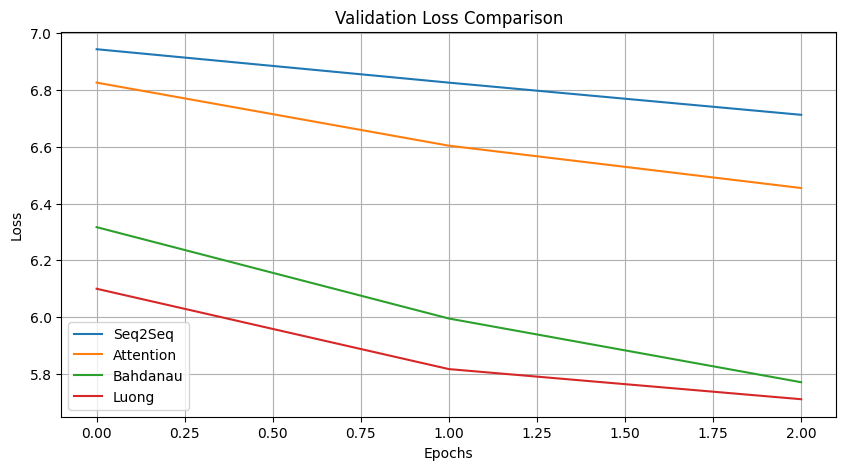

In [128]:
plt.figure(figsize=(10,5))

plt.plot(history_seq2seq.history['val_loss'], label='Seq2Seq')
plt.plot(history_attn.history['val_loss'], label='Attention')
plt.plot(hist_bahdanau.history['val_loss'], label='Bahdanau')
plt.plot(hist_luong.history['val_loss'], label='Luong')

plt.title("Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

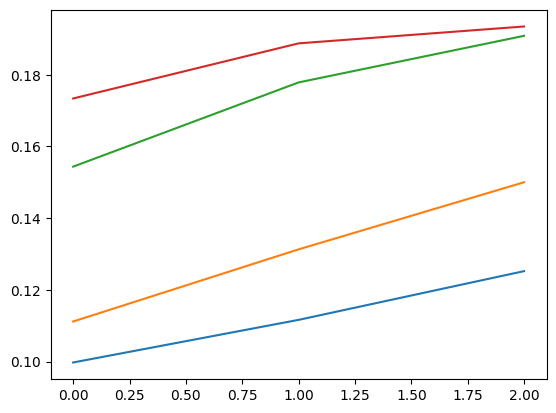

In [124]:
plt.plot(history_seq2seq.history['val_accuracy'], label='Seq2Seq')
plt.plot(history_attn.history['val_accuracy'], label='Attention')
plt.plot(hist_bahdanau.history['val_accuracy'], label='Bahdanau')
plt.plot(hist_luong.history['val_accuracy'], label='Luong')

# PREDICT ON VALIDATION SAMPLE

In [125]:
def decode_sequence(model, input_seq):
    decoded = 'sostok'
    for _ in range(MAX_SUM_LEN):
        seq = y_tokenizer.texts_to_sequences([decoded])
        seq = pad_sequences(seq, maxlen=MAX_SUM_LEN, padding='post')
        preds = model.predict([input_seq, seq], verbose=0)
        next_word_id = np.argmax(preds[0, -1, :])
        next_word = y_tokenizer.index_word.get(next_word_id, '')
        if next_word == 'eostok':
            break
        decoded += ' ' + next_word
    return decoded

In [127]:
i = 7
print("ARTICLE:", val_df.iloc[i]['article'][:500])
print("\nACTUAL SUMMARY:", val_df.iloc[i]['highlights'])
print("\nSEQ2SEQ:", decode_sequence(seq2seq_model, x_val[i:i+1]))
print("\nBAHDANAU:", decode_sequence(bahdanau_model, x_val[i:i+1]))
print("\nLUONG:", decode_sequence(luong_model, x_val[i:i+1]))

ARTICLE: one of the convictedbali nine drug smugglers facing life in an indonesian prison has spoken of his terror for fellow traffickers andrew chan and myuran sukumaran in an emotional online plea for help tan duc thanh nguyen was arrested with chan and sukumaran in for his role in a plot to smuggle kg of heroin out of bali and into australia in an online campaign to raise funds for a fifth appeal against his life sentence the yearold describes his anguish for the first time today as sit in my jail cel

ACTUAL SUMMARY: sostok bali nine drug smuggler tan duc thanh nguyen was convicted in he has spent ten years behind bars for his role in the drug smuggling plot am i guilty yes am i sorry more than anyone will ever know he says nguyen was jailed for life but is terrified of being given a death sentence the yearold has launched a desperate online plea for help to raise funds for another legal appealto reduce his sentence while they are alive we have hope he says of chan and sukumaran eo